In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import glob
import pickle

In [0]:
data_path = '/content/drive/My Drive/Mineria de datos/datasets/ready/'

training_sets_paths = sorted(glob.glob(data_path + "training*.pkl"))
test_sets_paths = sorted(glob.glob(data_path + 'test*.pkl'))

In [0]:
dataset_index = 0

In [0]:
TRAINING = pd.read_pickle(training_sets_paths[dataset_index])
TEST = pd.read_pickle(test_sets_paths[dataset_index])

### One Hot Encoding

In [0]:
columns_fe = []

for i in range(1, 3):
    columns_fe.append('hist_user_behavior_reason_start'+str(i))
    columns_fe.append('hist_user_behavior_reason_end'+str(i))
    columns_fe.append('mode'+str(i))
    columns_fe.append('context_type'+str(i))

In [0]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

ENCODED_training = []
ENCODED_test = []
for column in columns_fe:
    le = LabelEncoder()
    ohe = OneHotEncoder()

    le.fit(pd.concat([TRAINING[column], TEST[column]], ignore_index=True))

    TEMP_train = le.transform(TRAINING[column])
    TEMP_test  = le.transform(TEST[column])

    ohe.fit(np.append(TEMP_train, TEMP_test).reshape(-1,1))

    X_train = ohe.transform(TEMP_train.reshape(-1,1)).toarray()
    X_test  = ohe.transform(TEMP_test.reshape(-1,1)).toarray()


    ENCODED_training.append(
        pd.DataFrame(X_train, columns=[column+str(i) for i in range(X_train.shape[1])])
    )

    ENCODED_test.append(
        pd.DataFrame(X_test, columns=[column+str(i) for i in range(X_test.shape[1])])
    )

In [0]:
TRAINING = pd.concat([TRAINING] + ENCODED_training, axis=1)
TEST = pd.concat([TEST] + ENCODED_test, axis=1)

In [0]:
TRAINING.drop(columns_fe, axis=1, inplace=True)
TEST.drop(columns_fe, axis=1, inplace=True)

In [0]:
TRAINING

### Getting ready

In [0]:
features_column_names = list(TRAINING.columns)
features_column_names.remove('skip')
features_column_names.remove('session_length')
features_column_names.remove('session_position')
features_column_names.remove('session_id')

In [0]:
split_cant_start = 1000
train_indexes = list(TRAINING.index.values)

train_splits = []
split_size = split_cant_start
while split_size < len(train_indexes):
    train_splits.append(train_indexes[:split_size])
    del train_indexes[:split_size]
    split_size = split_size*2

train_splits.append(train_indexes)

for s in train_splits:
    print(len(s))

1000
2000
4000
8000
16000
32000
64000
128000
256000
512000
1024000
2048000
1011742


## Training

### Naive Bayes

In [0]:
from sklearn.naive_bayes import ClassifierMixin
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB



### Decision Tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

### Ensemble: Bagging Decision Trees

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection

In [0]:
RANDOM_STATE = 100
n_estimators = [80, 90, 100, 150, 200]
max_samples = [0.4, 0.6, 0.8, 1.0]

In [0]:
xval_results = []
kfold = model_selection.KFold(
    n_splits=10, 
    random_state=RANDOM_STATE,
    shuffle=True
)

#### Evaluating the params

In [0]:
for n_estimator in n_estimators:
    for max_sample in max_samples:
        bag_model = BaggingClassifier(
            base_estimator=DecisionTreeClassifier(),
            n_estimators=n_estimator,
            max_samples=max_sample,
            bootstrap=True
        )
        xval_result = model_selection.cross_val_score(
            bag_model,
            X=TRAINING.loc[train_splits[1] , features_column_names], 
            y=TRAINING.loc[train_splits[1] , 'skip'], 
            cv=kfold
        )
        print(xval_result)
        xval_results.append(xval_result)

[0.865 0.88  0.91  0.87  0.875 0.87  0.845 0.86  0.795 0.89 ]
[0.87  0.88  0.905 0.865 0.895 0.875 0.84  0.895 0.8   0.9  ]
[0.855 0.85  0.91  0.855 0.885 0.86  0.855 0.865 0.785 0.895]
[0.86  0.875 0.91  0.87  0.885 0.86  0.865 0.88  0.795 0.89 ]
[0.885 0.87  0.92  0.875 0.9   0.86  0.85  0.89  0.79  0.91 ]
[0.855 0.865 0.92  0.87  0.91  0.87  0.855 0.885 0.775 0.895]
[0.845 0.87  0.905 0.885 0.88  0.875 0.89  0.865 0.775 0.89 ]
[0.865 0.875 0.915 0.875 0.895 0.87  0.865 0.87  0.77  0.89 ]
[0.87  0.875 0.905 0.875 0.9   0.87  0.865 0.905 0.77  0.885]
[0.855 0.855 0.895 0.865 0.895 0.885 0.865 0.9   0.765 0.895]
[0.845 0.875 0.92  0.845 0.885 0.86  0.875 0.875 0.755 0.885]
[0.84  0.86  0.92  0.875 0.89  0.86  0.855 0.86  0.785 0.885]
[0.86  0.87  0.905 0.865 0.885 0.875 0.86  0.875 0.79  0.89 ]
[0.86  0.875 0.91  0.865 0.89  0.875 0.87  0.88  0.775 0.885]
[0.85  0.865 0.9   0.86  0.89  0.885 0.87  0.875 0.765 0.895]
[0.845 0.865 0.91  0.89  0.885 0.865 0.86  0.88  0.765 0.89 ]
[0.86  0

In [0]:
for x in xval_results:
    print(x.mean())

In [0]:
n_estimators_indexes = []
max_samples_indexes = []

for n_estimator in n_estimators:
    for max_sample in max_samples:
        n_estimators_indexes.append(f'n_estimators_{n_estimator}')
        max_samples_indexes.append(f'max_samples_{max_sample}')

In [0]:
xval_results_df = pd.DataFrame(
    np.zeros((20, 1)), 
    columns=['score'], 
    index=[ np.array(n_estimators_indexes), np.array(max_samples_indexes)]
)

In [0]:
i=0
for n_estimator in n_estimators:
    for max_sample in max_samples:
        xval_results_df.loc[(
                                f'n_estimators_{n_estimator}', 
                                f'max_samples_{max_sample}'
                            ),
                            'score'] = xval_results[i].mean()
        i+=1

In [0]:
#xval_results_df.reset_index(inplace=True)
#xval_results_df.columns = ['n_estimators', 'max_samples', 'score']

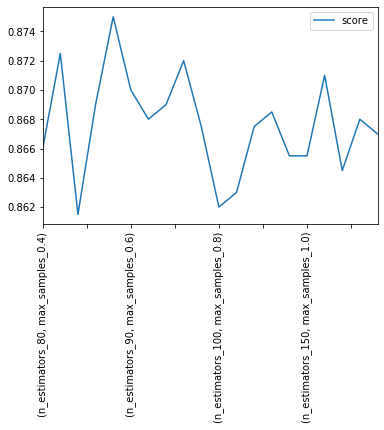

In [0]:
xval_results_df.plot(rot=90)

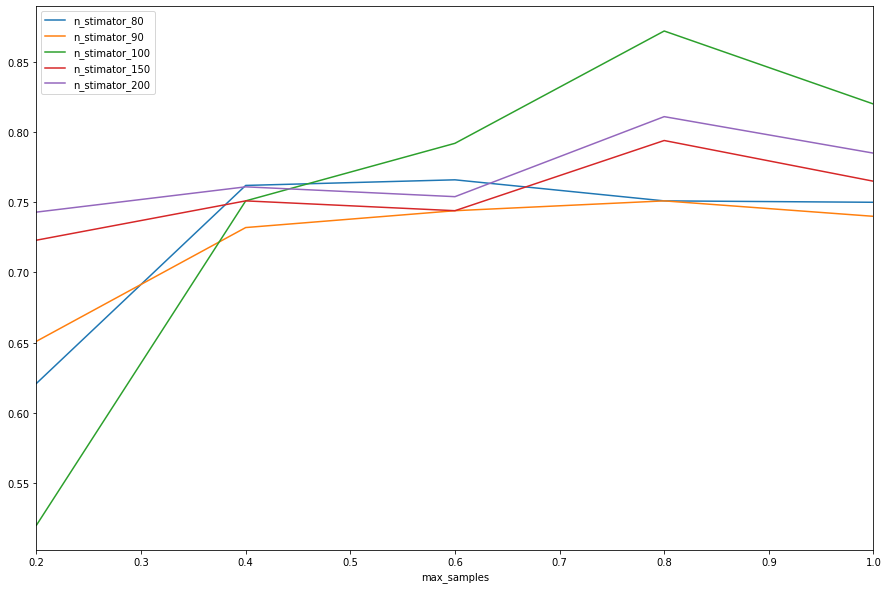

In [0]:
d_df.plot(x='max_samples', figsize=(15, 10))

In [0]:
with open('/content/drive/My Drive/Mineria de datos/datasets/validations/bag_xval.pkl', 'wb') as f:
    pickle.dump(xval_results, f)

#### Building the model with selected configuration.

In [0]:
bag_model = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=0.8,
    bootstrap=True
)

In [0]:
performance_results = []  # accuracy | average accuracy | data size

In [0]:
train_splits_index = 4

In [0]:
bag_model.fit(
    X=TRAINING.loc[train_splits[train_splits_index], features_column_names],
    y=TRAINING.loc[train_splits[train_splits_index], ['skip']]
)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [0]:
pred = bag_model.predict(TEST.loc[train_splits[3] , features_column_names])

In [0]:
actual = get_ground_truth(TEST.loc[train_splits[3], ['skip', 'session_length', 'session_position']])

In [0]:
predicted = get_ground_truth(pd.concat(
    [
        TEST.loc[train_splits[3], ['session_length', 'session_position']].reset_index(drop=True),
        pd.DataFrame(pred, columns=['skip'])
     ], 
     axis=1)
)

In [0]:
average_score, acurracy = evaluate(predicted, actual)

In [0]:
performance_results.append(
    [
        average_score, 
        acurracy, 
        sum(map(lambda l: len(l), train_splits[ :train_splits_index + 1]))
    ])
performance_results

[[0.7618483026861619, 0.7653061224489796, 1000],
 [0.767121500221237, 0.8020408163265306, 3000],
 [0.7617477655069661, 0.8163265306122449, 7000],
 [0.782529443443779, 0.810204081632653, 15000],
 [0.7697943742177132, 0.7959183673469388, 31000]]

In [0]:
lc_results

,average_score,Training,data size,xval
0,0.744822,0.812120,1000.0,0.729148
1,0.752490,0.812120,3000.0,0.760706
2,0.756787,0.767731,7000.0,0.793731
3,0.759486,0.779733,15000.0,0.759733
4,0.761682,0.781420,31000.0,0.775420
5,0.764527,0.784163,63000.0,0.790163
6,0.765828,0.789833,127000.0,0.793833
7,0.765591,0.793122,255000.0,0.797122
8,0.768910,0.793241,511000.0,0.803241
9,0.768078,0.825128,1023000.0,0.805128


In [0]:
lc_results.columns = ['average_score', 'Training', 'data size', 'xval']

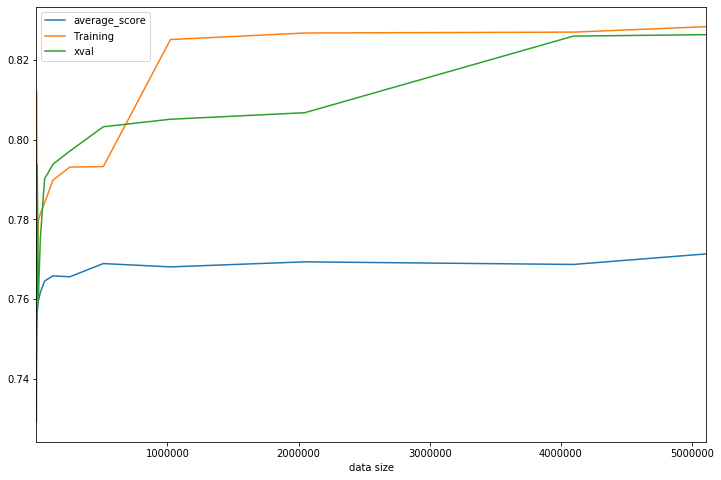

In [0]:
lc_results.plot(y=['average_score', 'Training', 'xval'], x='data size', figsize=(12, 8))

In [0]:
pred = bag_model.predict(TEST.loc[train_splits[3], features_column_names])

In [0]:
actual = get_ground_truth(TEST.loc[train_splits[3], ['skip', 'session_length', 'session_position']])

In [0]:
predicted = get_ground_truth(
    pd.concat(
    [
        TEST.loc[train_splits[3], ['session_length', 'session_position']].reset_index(drop=True),
        pd.DataFrame(pred, columns=['skip']).reset_index(drop=True)
     ], 
     axis=1
     )
)

In [0]:
average_score, acurracy = evaluate(predicted, actual)

In [0]:
average_score, acurracy

(0.77507063329633, 0.8020408163265306)

### Ensemble: Gradient Boosting trees.

#### Cross-validation

In [0]:
import xgboost as xgb

In [0]:
RANDOM_STATE = 100
params = {
    'eta':0.1,
    'max_depth':11,
    'n_estimators':100,
    'tree_method':'gpu_hist',
    'random_state': RANDOM_STATE
}

In [0]:
max_depths = [10, 11, 12, 13]
etas = [0.01, 0.05, 0.1, 0.15, 0.2]
n_estimators = [90, 100, 110, 120]

In [0]:
xg_train = xgb.DMatrix(
    TRAINING.loc[train_splits[0], features_column_names], 
    TRAINING.loc[train_splits[0], 'skip']
)

In [0]:
results = []
for max_depth in max_depths:
    for learning_rate in etas:
        for n_estimator in n_estimators:
            params['max_depth'] = max_depth
            params['eta'] = learning_rate
            params['n_estimators'] = n_estimator
            params['objective'] = 'binary:logistic'
            result = xgb.cv(
                params,
                xg_train, 
                nfold=10,
                stratified=False,
                verbose_eval=False
            )
            print(params)
            results.append(result)

In [0]:
## Save the results in disk
with open('/content/drive/My Drive/Mineria de datos/datasets/validations/xgb_xval.pkl', 'wb') as f:
    pickle.dump(results, f)

In [0]:
## Read the results from disk
with open('/content/drive/My Drive/Mineria de datos/datasets/validations/xgb_xval.pkl', 'rb') as f:
    xval_results = pickle.load(f)

In [0]:
xval_results = [
                 [round(r['train-error-mean'].mean(), 5),  round(r['test-error-mean'].mean(), 5)] for r in xval_results
                ]

In [0]:
xval_results

Creating all the params combinations. It will used for pandas indexing to build the plots.

In [0]:
max_depths_indexes = []
etas_indexes = []
n_estimators_indexes = []

for max_depth in max_depths:
    for learning_rate in etas:
        for n_estimator in n_estimators:
            max_depths_indexes.append(f'max_depth_{max_depth}')
            etas_indexes.append(f'learning_rate_{learning_rate}')
            n_estimators_indexes.append(f'n_estimators_{n_estimator}')

In [0]:
xval_results_df = pd.DataFrame(
    np.zeros((80, 2)), 
    columns=['train_error_mean', 'test_error_mean'], 
    index=[np.array(max_depths_indexes), np.array(etas_indexes), np.array(n_estimators_indexes)]
)

Filling the dataframe with results

In [0]:
i=0
for max_depth in max_depths:
    for learning_rate in etas:
        for n_estimator in n_estimators:
            xval_results_df.loc[(
                                f'max_depth_{max_depth}', 
                                f'learning_rate_{learning_rate}', 
                                f'n_estimators_{n_estimator}'
                                ),
                                'train_error_mean'] = xval_results[i][0]
            xval_results_df.loc[(
                                f'max_depth_{max_depth}', 
                                f'learning_rate_{learning_rate}', 
                                f'n_estimators_{n_estimator}'
                                ),
                                'test_error_mean'] = xval_results[i][1]
            i+=1

In [0]:
xval_results_df

Plot results

In [0]:
a = xval_results_df.loc[f'max_depth_10'].reset_index()

In [0]:
a.groupby(['level_0', 'level_1']).mean().plot(rot=90)

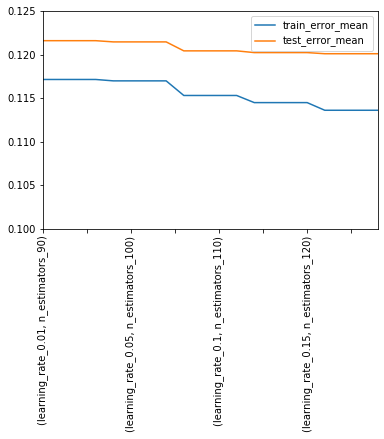

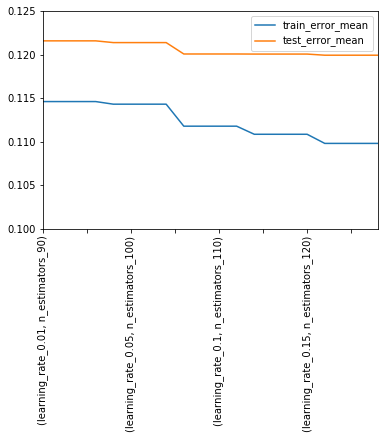

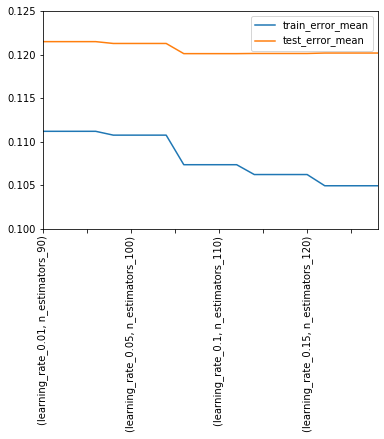

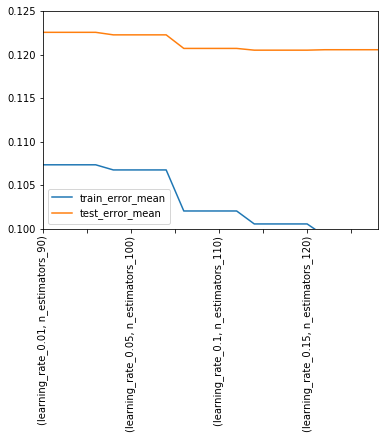

In [0]:
for max_depth in max_depths:
    xval_results_df.loc[f'max_depth_{max_depth}'].plot(rot=90, sharex=True, ylim=(0.1, 0.125))

#### Building the model with selected configuration.

In [0]:
xg_model = xgb.XGBClassifier(
    eta=0.1,
    max_depth=12,
    n_estimators=110,
    tree_method='gpu_hist'
)

#### Trying with diferent dataset sizes

In [0]:
performance_results = []  # accuracy | average accuracy | data size

In [0]:
learning_progress = {} # mae Mean Absolute Error

In [0]:
train_splits_index = 0

In [0]:
## Run this block once, no more
xg_model.fit(
    X=TRAINING.loc[train_splits[train_splits_index] + train_splits[4], features_column_names], 
    y=TRAINING.loc[train_splits[train_splits_index] + train_splits[4], 'skip'],
    xgb_model=None,
    eval_set=[
              (
                TRAINING.loc[train_splits[train_splits_index] + train_splits[4], features_column_names], 
                TRAINING.loc[train_splits[train_splits_index] + train_splits[4], 'skip']
               ),
              (
                TEST.loc[train_splits[train_splits_index] + train_splits[4], features_column_names],
                TEST.loc[train_splits[train_splits_index] + train_splits[4], 'skip']
                )
              ],
    verbose=False,
    eval_metric="error",
    early_stopping_rounds=10
)

## Save the model in disk
with open(f'/content/drive/My Drive/Mineria de datos/datasets/models/xgb_split{train_splits_index}.pkl', 'wb') as f:
    pickle.dump(xg_model, f)

In [0]:
xg_model.best_iteration

31

In [0]:
evals_result = xg_model.evals_result()

In [0]:
evals_result

In [0]:
evals_result['validation_0'] = evals_result['validation_0']['error']
evals_result['validation_1'] = evals_result['validation_1']['error']

In [0]:
evals_result = pd.DataFrame(evals_result)

In [0]:
evals_result.columns = ['train', 'test']

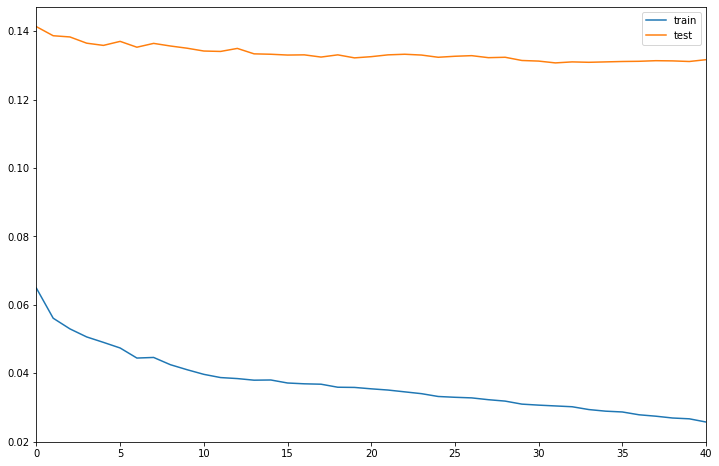

In [0]:
evals_result.plot(y=['train', 'test'], figsize=(12,8))

Fit again to the existing model with more data.

In [0]:
last_model = {}
with open(f'/content/drive/My Drive/Mineria de datos/datasets/models/xgb_split{train_splits_index-1}.pkl', 'rb') as f:
    last_model = pickle.load(f)

In [0]:
xg_model.fit(
    X=TRAINING.loc[train_splits[train_splits_index], features_column_names], 
    y=TRAINING.loc[train_splits[train_splits_index], 'skip'],
    xgb_model=last_model.get_booster()
)

In [0]:
## Save the new model in disk
with open(f'/content/drive/My Drive/Mineria de datos/datasets/models/xgb_split{train_splits_index}.pkl', 'wb') as f:
    pickle.dump(xg_model, f)

### GroundTruth

#### Utils

In [0]:
def get_ground_truth(input_df):
    ground_truths = []     
    df = input_df.reset_index()
    current_index = 0
    # Here we process each session.
    while current_index < len(df):
        partial_length = df['session_length'].iloc[current_index]-df['session_position'].iloc[current_index]+1
        session_skips = list(df.loc[current_index:current_index+partial_length-1, 'skip'])
        ground_truths.append(session_skips)
        current_index += partial_length 
    return ground_truths


def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc

def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)


#### Performance Evaluation

In [0]:
pred = xg_model.predict(TEST[features_column_names])

In [0]:
actual = get_ground_truth(TEST[['skip', 'session_length', 'session_position']])

In [0]:
predicted = get_ground_truth(pd.concat(
    [
        TEST[['session_length', 'session_position']],
        pd.DataFrame(pred, columns=['skip'])
     ], 
     axis=1)
)

In [0]:
average_score, acurracy = evaluate(predicted, actual)

In [0]:
average_score, acurracy

(0.7915466723288993, 0.8364760918847378)

In [0]:
performance_results.append(
    [
        average_score, 
        acurracy, 
        sum(map(lambda l: len(l), train_splits[ :train_splits_index + 1]))
    ])

In [0]:
performance_results

In [0]:
with open(f'/content/drive/My Drive/Mineria de datos/datasets/models/xgb_performance_result.pkl', 'wb') as f:
    pickle.dump(performance_results, f)

In [0]:
with open(f'/content/drive/My Drive/Mineria de datos/datasets/models/xgb_performance_result.pkl', 'rb') as f:
    performance_results = pickle.load(f)
performance_results

[[0.7548220821177558, 0.7691481136896728, 1000],
 [0.7624903529504591, 0.7807057775215231, 3000],
 [0.7667868640568112, 0.7937310812050371, 7000],
 [0.7694857126609737, 0.7997326798841613, 15000],
 [0.7726815766910747, 0.8054197843093576, 31000],
 [0.7745274502538488, 0.81016340597277, 63000],
 [0.7758284833238206, 0.8138325056019289, 127000],
 [0.7755910138725567, 0.8171215913409249, 255000],
 [0.7789101909047557, 0.8232411253652719, 511000],
 [0.7780783727762007, 0.8251280908888394, 1023000],
 [0.779344167242049, 0.8267660817947139, 2047000],
 [0.7786907837085372, 0.8269888485579128, 4095000],
 [0.7813351825888115, 0.8283516569916004, 5106742]]

Learning Curve

In [0]:
performance_results_df = pd.DataFrame(performance_results, columns=['average_score', 'acurracy', 'xval', 'data size'])

In [0]:
performance_results_df.columns= ['average_score', 'training', 'data size', 'xval']

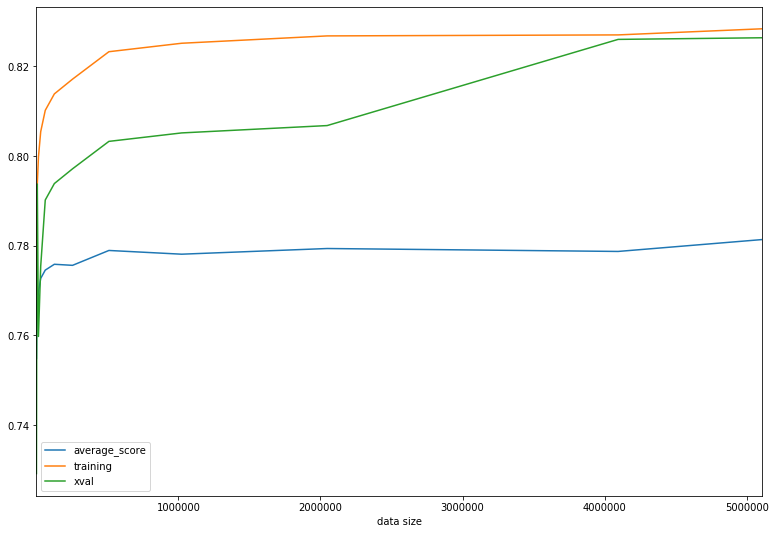

In [0]:
performance_results_df.plot(y=['average_score', 'training', 'xval'], x='data size', figsize=(13, 9))